## Sarima Models 

This Sarima model will be using the 1 year hourly dataset.  This dataset has 8731 Data points compared to about 550 in the previous model.  I expect this new data to have much better results

In [66]:
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols, adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AR,ARResults
from statsmodels.tools.eval_measures import mse,rmse
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima

In [5]:
# Importing the Dataframe
df = pd.read_csv('df_pt.csv')
df.drop('Unnamed: 0', axis = 1, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds', inplace=True, )
df.columns = ['power']
df.fillna(1353772, inplace=True)
df.index.freq = '1H'

In [24]:
df.head()

,power
ds,
2018-11-14 14:17:00,1580461.625
2018-11-14 15:17:00,2057284.438
2018-11-14 16:17:00,1567539.813
2018-11-14 17:17:00,1446398.438
2018-11-14 18:17:00,1584766.063


### Testing for Seasonality 

In [12]:
result = adfuller(df['power'].dropna(),autolag='AIC')
print('ADF Statistic: ', result[0])
print('p-value: ',  result[1])

ADF Statistic:  -7.504842779756211
p-value:  4.160854213927059e-11


#### Data is stationary

## Auto Regression¶

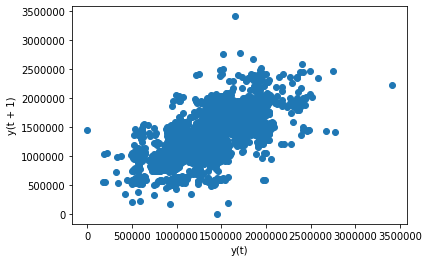

In [16]:
# Slight Positive Correlation
lag_plot(df['power'])

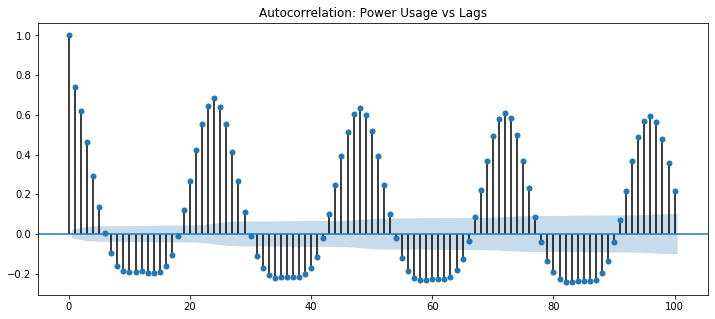

In [22]:
title = 'Autocorrelation: Power Usage vs Lags'
lags = 100
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(df['power'],title=title,lags=lags, ax=ax);

#### Can clearly see in the above Autocorrelation plot that every 24th lag there is a high correlation.  This is expected since every cycle is 24 hours. 

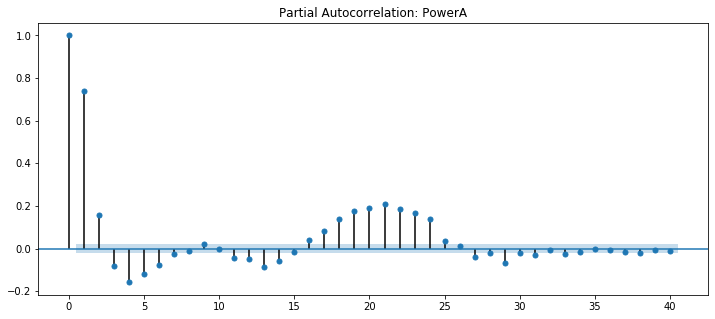

In [25]:
title='Partial Autocorrelation: PowerA'
lags=40
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(df['power'],title=title,lags=lags, ax=ax);

### Autoregression Visualization

In [29]:
train_data = df.iloc[:8570]
test_data = df.iloc[8570:]
start=len(train_data)
end=len(train_data)+len(test_data)-1

model = AR(train_data['power'])
AR1fit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR1fit.k_ar}')
print(f'Coefficients:\n{AR1fit.params}')

Lag: 1
Coefficients:
const       354579.736668
L1.power         0.737449
dtype: float64


Lag: 1
Coefficients:
const       354579.736668
L1.power         0.737449
dtype: float64


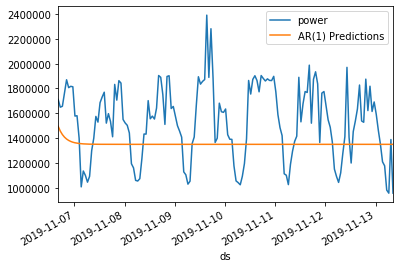

In [32]:
# Autoregression lag of 1 not helful as its basically a stright line 
ARfit = model.fit(maxlag=1,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')
predictions1 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')
test_data['power'].plot(legend=True)
predictions1.plot(legend=True)


### Graphing the Autoregression plots to see the improvement.  Notice how much it improves as the lag gets closer to the cycle peaks 24 lags out

- Actual Power Consumption Data is in Blue 
- Previous Autocorrelation is in orange 
- Current Autocorrelation in Green 

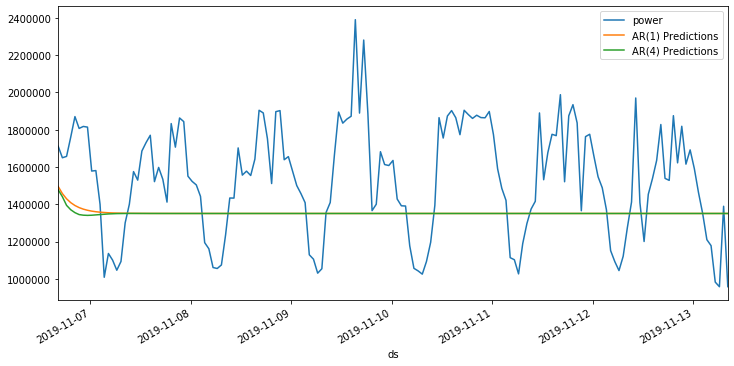

In [56]:
# Autoregression lag of 4 still not very helpful.  Lag of 1 and 4 barely differ 
ARfit = model.fit(maxlag=4,method='mle')
# print(f'Lag: {ARfit.k_ar}')
# print(f'Coefficients:\n{ARfit.params}')
predictions4 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(4) Predictions')
test_data['power'].plot(legend=True)
predictions1.plot(legend=True)
predictions4.plot(legend=True,figsize=(12,6));

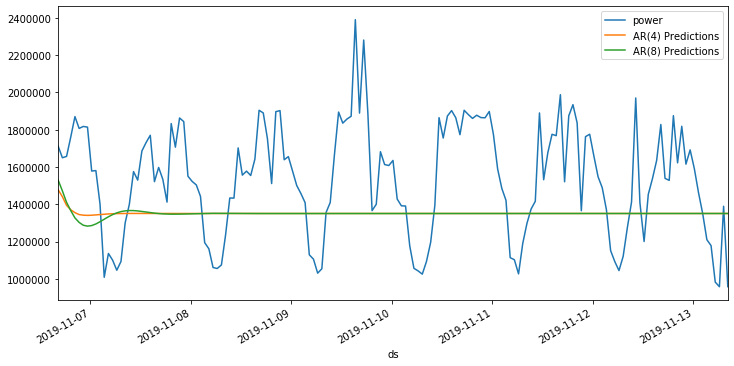

In [57]:
# Autoregression lag of 8 not useful 
ARfit = model.fit(maxlag=8,method='mle')
# print(f'Lag: {ARfit.k_ar}')
# print(f'Coefficients:\n{ARfit.params}')
predictions8 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(8) Predictions')
test_data['power'].plot(legend=True)
predictions4.plot(legend=True)
predictions8.plot(legend=True,figsize=(12,6));

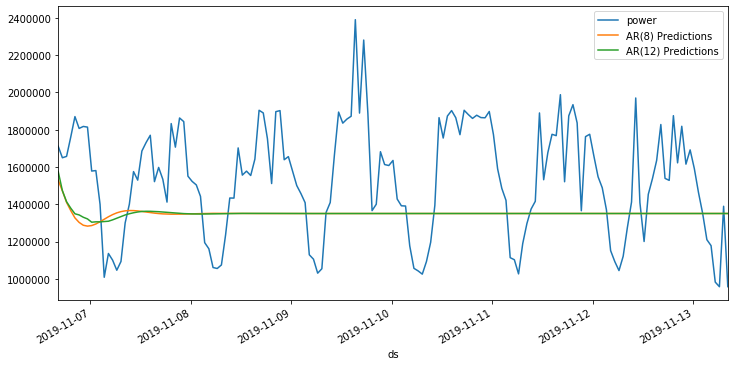

In [58]:
# Autoregression lag of 12 starting to see some trend in the beginning, but still not very useful 
ARfit = model.fit(maxlag=12,method='mle')
# print(f'Lag: {ARfit.k_ar}')
# print(f'Coefficients:\n{ARfit.params}')
predictions12 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(12) Predictions')
test_data['power'].plot(legend=True)
predictions8.plot(legend=True)
predictions12.plot(legend=True,figsize=(12,6));

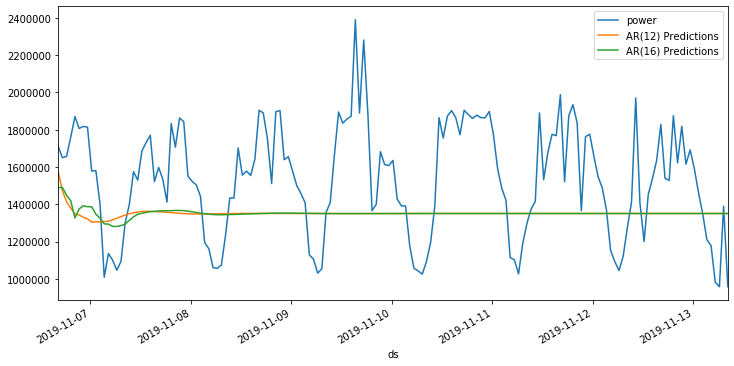

In [47]:
# Autoregression lag of 16 
ARfit = model.fit(maxlag=16,method='mle')
# print(f'Lag: {ARfit.k_ar}')
# print(f'Coefficients:\n{ARfit.params}')
predictions16 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(16) Predictions')
test_data['power'].plot(legend=True)
predictions12.plot(legend=True)
predictions16.plot(legend=True,figsize=(12,6));

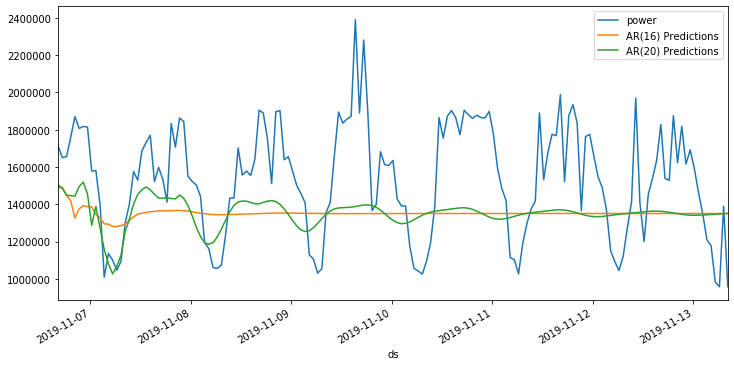

In [59]:
# Autoregression lag of 20 now starting to see more of a trend and how this could be useful in a model 
ARfit = model.fit(maxlag=20,method='mle')
# print(f'Lag: {ARfit.k_ar}')
# print(f'Coefficients:\n{ARfit.params}')
predictions20 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(20) Predictions')
test_data['power'].plot(legend=True)
predictions16.plot(legend=True)
predictions20.plot(legend=True,figsize=(12,6));

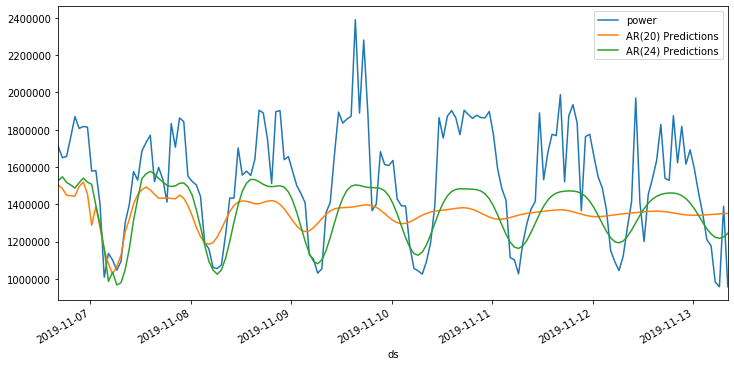

In [49]:
# Autoregression lag of 24 as expected holds the trend all the way through the 1 week prediction.  The first 48 hours 
# it actually gets very well
ARfit = model.fit(maxlag=24,method='mle')
# print(f'Lag: {ARfit.k_ar}')
# print(f'Coefficients:\n{ARfit.params}')
predictions24 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(24) Predictions')
test_data['power'].plot(legend=True)
predictions20.plot(legend=True)
predictions24.plot(legend=True,figsize=(12,6));

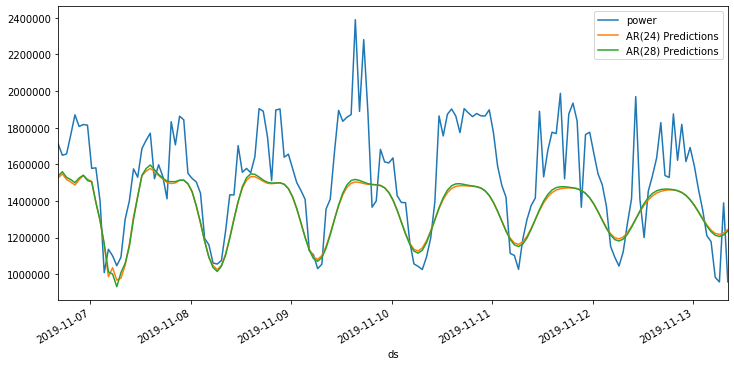

In [50]:
# Autoregression lag of 28
ARfit = model.fit(maxlag=28,method='mle')
# print(f'Lag: {ARfit.k_ar}')
# print(f'Coefficients:\n{ARfit.params}')
predictions28 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(28) Predictions')
test_data['power'].plot(legend=True)
predictions24.plot(legend=True)
predictions28.plot(legend=True,figsize=(12,6));

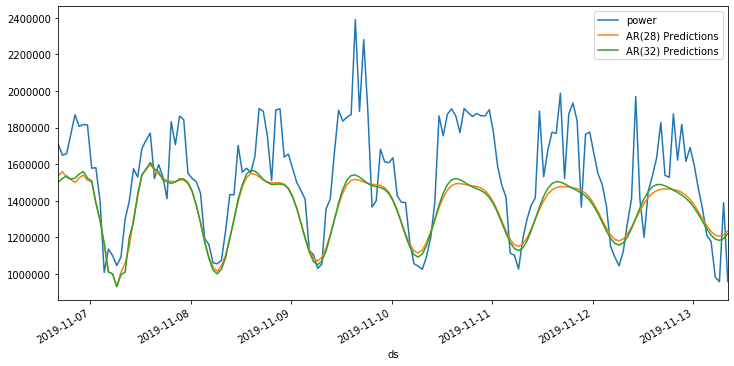

In [51]:
# Autoregression lag of 32
ARfit = model.fit(maxlag=32,method='mle')
# print(f'Lag: {ARfit.k_ar}')
# print(f'Coefficients:\n{ARfit.params}')
predictions32 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(32) Predictions')
test_data['power'].plot(legend=True)
predictions28.plot(legend=True)
predictions32.plot(legend=True,figsize=(12,6));

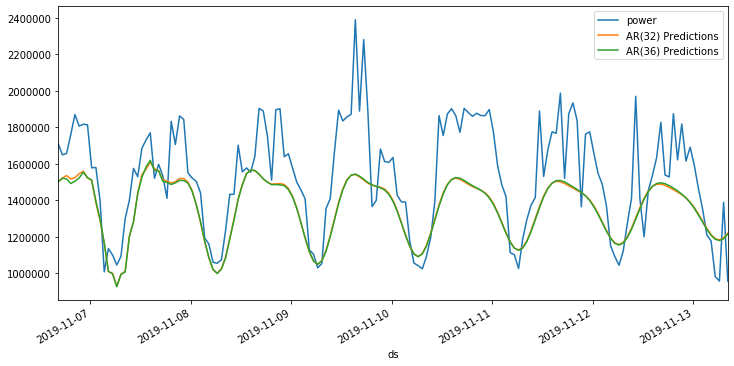

In [53]:
# Autoregression lag of 36
ARfit = model.fit(maxlag=36,method='mle')
# print(f'Lag: {ARfit.k_ar}')
# print(f'Coefficients:\n{ARfit.params}')
predictions36 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(36) Predictions')
test_data['power'].plot(legend=True)
predictions32.plot(legend=True)
predictions36.plot(legend=True,figsize=(12,6));

/Users/eric/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


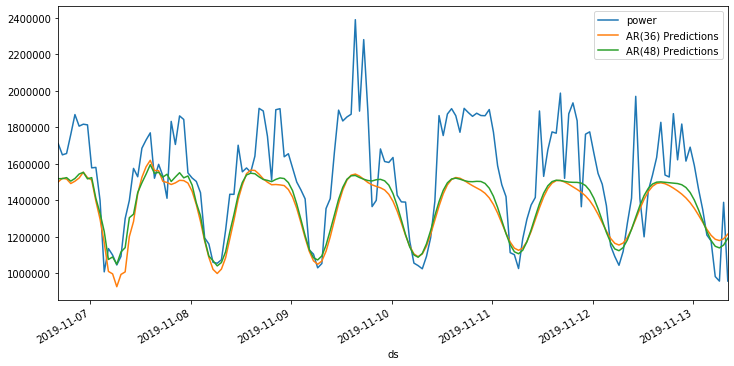

In [55]:
# Autoregression lag of 48 two cycles out 
ARfit = model.fit(maxlag=48,method='mle')
# print(f'Lag: {ARfit.k_ar}')
# print(f'Coefficients:\n{ARfit.params}')
predictions48 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(48) Predictions')
test_data['power'].plot(legend=True)
predictions36.plot(legend=True)
predictions48.plot(legend=True,figsize=(12,6));

#### Interesting to chart out the different lags to actually see how it helps in predicting in Sarima Models.  Once the lag order got closer to 24 which is one full cycle the autoregression picked up the trend pretty well.  

# Building the Final Sarima Model 

In [ ]:
# Running auto arima once more without params 
power_sarima = auto_arima(df['power'], seasonal=True, m=24)

In [64]:
# SARIMAX(2, 1, 1)x(2, 0, 1, 24)
power_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8731
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 24)   Log Likelihood             -118569.631
Date:                            Fri, 20 Dec 2019   AIC                         237155.261
Time:                                    13:48:55   BIC                         237211.857
Sample:                                         0   HQIC                        237174.549
                                           - 8731                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.8763      0.296     -2.963      0.003      -1.456      -0.297
ar.L1          0.2949      0.013     23.012      0.000       0.270       0.320
ar.L2          0.1286      0.013      9.633      0.000       0.102       0.155
ma.L1         -0.9724      0.004   -257.760      0.000      -0.980      -0.965
ar.S.L24       1.0603      0.016     68.180      0.000       1.030       1.091
ar.S.L48      -0.0621      0.015     -4.021      0.000      -0.092      -0.032
ma.S.L24      -0.9655      0.005   -176.566      0.000      -0.976      -0.955
sigma2      5.146e+10   5.02e-12   1.02e+22      0.000    5.15e+10    5.15e+10
===================================================================================
Ljung-Box (Q):                      134.62   Jarque-Bera (JB):              8443.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.62e+38. Standard errors may be unstable.
"""

In [67]:
model = SARIMAX(df['power'],order=(2, 1, 1),seasonal_order=(2, 0, 1, 24))
power_results = model.fit()
power_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              power   No. Observations:                 8731
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 24)   Log Likelihood             -118563.501
Date:                            Fri, 20 Dec 2019   AIC                         237141.003
Time:                                    14:10:45   BIC                         237190.524
Sample:                                11-14-2018   HQIC                        237157.879
                                     - 11-13-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2911      0.013     22.900      0.000       0.266       0.316
ar.L2          0.1237      0.012     10.461      0.000       0.101       0.147
ma.L1         -0.9671      0.004   -216.092      0.000      -0.976      -0.958
ar.S.L24       1.0654      0.004    245.383      0.000       1.057       1.074
ar.S.L48      -0.0662      0.004    -15.181      0.000      -0.075      -0.058
ma.S.L24      -0.9760      0.004   -224.591      0.000      -0.985      -0.967
sigma2      5.146e+10   2.13e-14   2.41e+24      0.000    5.15e+10    5.15e+10
===================================================================================
Ljung-Box (Q):                      135.08   Jarque-Bera (JB):              8393.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.82e+38. Standard errors may be unstable.
"""

In [68]:
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = power_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(2, 1, 1)x(2, 0, 1, 24)')

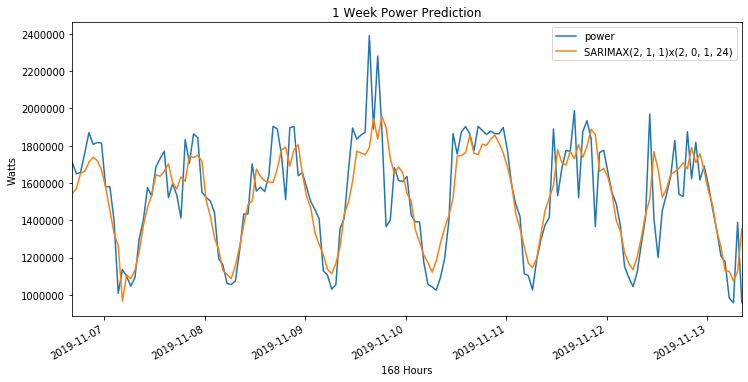

In [69]:
# Plot predictions against known values
title = '1 Week Power Prediction'
ylabel='Watts'
xlabel='168 Hours'

ax = test_data['power'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [72]:
mse = mse(test_data['power'], predictions)
rmse = rmse(test_data['power'], predictions)

print(f'SARIMAX(2, 1, 1)x(2, 0, 1, 24) MSE {mse}')
print(f'SARIMAX(2, 1, 1)x(2, 0, 1, 24) RMSE Error: {rmse}')

SARIMAX(2, 1, 1)x(2, 0, 1, 24) MSE 25598520140.655807
SARIMAX(2, 1, 1)x(2, 0, 1, 24) RMSE Error: 159995.37537271448


### The RMSE came for the sarima model came out to 159995 compared to 224000 when running the Facebook Prophet Model.  Visually you can see that the Sarima Model predicts the tops of each cycle way more accurately then Facebook Prophet.  

#### Overall the predictions are about 88% accurate which is pretty good considering no exogenous have been added into the model 